# Example
In this example, we'll use CESM1-LE to diagnose the forced response to external forcing near Woods Hole.

## Imports

In [1]:
import pathlib
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import seaborn as sns
import cmocean
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import copy
import pandas as pd

#this package shows our data loading progress
#Install, import, and then change the data loading line in the load_ensemble_helper func if you want to use
#import tqdm 

## (optional) remove gridlines from plots
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## should we save figs?
SAVE_FIGS = False

## Functions

In [2]:
def trim(data, lon_range, lat_range):
    """select part of data in given longitude/latitude range"""

    ## check if data is on the "T"-grid
    on_Tgrid = "TLONG" in data.coords

    ## handle trimming for T-grid
    if on_Tgrid:

        ## helper function to check if 'x' is in 'x_range'
        isin_range = lambda x, x_range: (x_range[0] <= x) & (x <= x_range[1])

        ## get mask for data in given lon/lat range
        in_lon_range = isin_range(data["TLONG"], lon_range)
        in_lat_range = isin_range(data["TLAT"], lat_range)
        in_lonlat_range = in_lon_range & in_lat_range

        ## load to memory
        in_lonlat_range.load()

        ## Retain all points with at least one valid grid cell
        x_idx = in_lonlat_range.any("nlat")
        y_idx = in_lonlat_range.any("nlon")

        ## select given points
        return data.isel(nlon=x_idx, nlat=y_idx)

    else:
        return data.sel(lon=slice(*lon_range), lat=slice(*lat_range))


def plot_setup(fig, projection, lon_range, lat_range, xticks=None, yticks=None):
    """Add a subplot to the figure with the given map projection
    and lon/lat range. Returns an Axes object."""

    ## increase resolution for projection
    ## (otherwise lines plotted on surface won't follow curved trajectories)
    projection.threshold /= 1000

    ## Create subplot with given projection
    ax = fig.add_subplot(projection=projection)

    ## Subset to given region
    extent = [*lon_range, *lat_range]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    ## draw coastlines
    ax.coastlines(linewidths=0.5)

    ## add tick labels
    if xticks is not None:

        ## add lon/lat labels
        gl = ax.gridlines(
            draw_labels=True,
            linestyle="-",
            alpha=0.1,
            linewidth=0.5,
            color="k",
            zorder=1.05,
        )

        ## specify which axes to label
        gl.top_labels = False
        gl.right_labels = False

        ## specify ticks
        gl.ylocator = mticker.FixedLocator(yticks)
        gl.xlocator = mticker.FixedLocator(xticks)

    return ax


def plot_box_outline(ax, lon_range, lat_range, c="k"):
    """
    Plot box outlining the specifed lon/lat range on given
    ax object.
    """

    ## get width and height
    height = lat_range[1] - lat_range[0]
    width = lon_range[1] - lon_range[0]

    ## add rectangle to plot
    ax.add_patch(
        mpatches.Rectangle(
            xy=[lon_range[0], lat_range[0]],
            height=height,
            width=width,
            transform=ccrs.PlateCarree(),
            facecolor="none",
            edgecolor=c,
            linewidth=1,
        )
    )

    return ax


def plot_setup_woodshole(fig):
    """Plot zoomed-in view of Woods Hole"""

    ## adjust figure size
    fig.set_size_inches(5, 3)

    ## set map projection to orthographic
    proj = ccrs.Orthographic(central_longitude=-67.5, central_latitude=40)

    ## Get ax object based on generic plotting function
    ax = plot_setup(
        fig,
        proj,
        lon_range=[-80, -60],
        lat_range=[35, 45],
        xticks=[-80, -70, -60],
        yticks=[35, 40, 45],
    )

    return fig, ax


def make_cb_range(amp, delta):
    """Make colorbar_range for cmo.balance
    Args:
        - 'amp': amplitude of maximum value for colorbar
        - 'delta': increment for colorbar
    """
    return np.concatenate(
        [np.arange(-amp, 0, delta), np.arange(delta, amp + delta, delta)]
    )


def get_empirical_pdf(x, bin_edges=None):
    """
    Estimate the "empirical" probability distribution function for the data x.
    In this case the result is a normalized histogram,
    Normalized means that integrating over the histogram yields 1.
    Returns the PDF (normalized histogram) and edges of the histogram bins
    """

    ## compute histogram
    if bin_edges is None:
        hist, bin_edges = np.histogram(x)

    else:
        hist, _ = np.histogram(x, bins=bin_edges)

    ## normalize to a probability distribution (PDF)
    bin_width = bin_edges[1:] - bin_edges[:-1]
    pdf = hist / (hist * bin_width).sum()

    return pdf, bin_edges


def get_autocorr(x, lags, month=None):
    """Get autocorrelation for data for multiple lags"""

    ## put autocorrelation for each lag in array
    autocorr = [get_autocorr_helper(x, lag, month) for lag in lags]

    ## convert to xr.DataArray
    autocorr = xr.concat(autocorr, dim=pd.Index(lags, name="lag"))
    # return xr.DataArray(autocorr, coords={"lag": lags})
    return autocorr


def get_autocorr_helper(x, lag, month=None):
    """Get autocorrelation of data for single lag"""

    ## return 1 for a lag of 0
    if lag == 0:
        return xr.ones_like(x.isel(time=0))

    ## get lagged version of x
    elif lag > 0:
        x_lagged = x.isel(time=slice(lag, None))
        x_ = x.isel(time=slice(None, -lag))

    else:
        x_lagged = x.isel(time=slice(None, lag))
        x_ = x.isel(time=slice(-lag, None))

    ## re-label time axis so arrays match
    x_lagged["time"] = x_.time

    ## subset for data from given month
    if month is not None:
        is_month = x_.time.dt.month == month
        x_ = x_.isel(time=is_month)
        x_lagged = x_lagged.isel(time=is_month)

    return xr.corr(x_, x_lagged, dim="time")


def load_simulation(varname, member_id, simulation_type, preprocess_func=None):
    """
    Load dataset for single simulation, for single variable.
    Arguments:
        - varname: name of variable to load, one of {"SST","PSL"}
        - member_id: ID of ensemble member to load, an integer in the range [1,10]
        - simulation_type: one of {"hist", "rcp85"}
        - preprocess func: optional preprocessing function to apply to the simulation
    Returns:
        - xarray dataarray with given data
    """

    ## Filepath to the CESM LENS dataset
    lens_fp = pathlib.Path("cmip6/data/cmip6/CMIP/NCAR/LENS")

    #### 1. get filepath to data
    data_fp = SERVER_FP / lens_fp / pathlib.Path(varname)

    #### 2. get naming pattern for files to open
    if simulation_type == "hist":
        file_pattern = f"*20TRC*.{member_id:03d}.*.nc"

    elif simulation_type == "rcp85":
        file_pattern = f"*RCP85*.{member_id:03d}.*.nc"

    else:
        print("Not a valid simulation type")

    #### 3. open the relevant datasets, applying preprocessing function
    fp = list(data_fp.glob(file_pattern))[0]
    data = preprocess_func(xr.open_dataset(fp, decode_timedelta=True))

    return data[varname].squeeze(drop=True).compute()

## Load data

### Set filepaths

````{admonition} To-do
Update the filepaths ```SERVER_FP``` and ```save_fp``` in the code cell below.  

Preprocessing all 35 ensemble members takes a "long time" ($\sim$ 30 minutes on a laptop), so we'll save the preprocessed data to a file (to be loaded if the script is run a second time).
````

In [3]:
## Path to file server
# SERVER_FP = pathlib.Path("/vortexfs1/share")
SERVER_FP = pathlib.Path("/Volumes")

## Specify folder location for saving trimmed data ("./" means current directory)
save_fp = pathlib.Path("./")

### Pre-processing functions

````{admonition} To-do
If you'd like to look at a different region, change ```lon_range``` and ```lat_range``` in the preprocessing function below.
````

In [4]:
def preprocess(data):
    """
    Preprocessing steps:
        1. trim to period 1920 - 2081
        2. trim in lon/lat space
        3. convert time dimension from cftime to datetime
    """

    ## trim in time
    data_ = data.sel(time=slice("1920-02", "2081-01"))

    ## trim in space
    data_ = trim(data_, lon_range=[280, 300], lat_range=[35, 45])

    ## update time dimension
    start_year = data_.time.isel(time=0).dt.year.item()
    start_month = data_.time.isel(time=0).dt.month.item()
    start_date = f"{start_year}-{start_month}-01"
    data_["time"] = pd.date_range(start=start_date, periods=len(data_.time), freq="MS")

    return data_

### Do the loading

````{note} 
Preprocessing the data in the code cell below is slow ($\sim 30$ minutes on a laptop). To speed up the process, here are two options:
1. load less ensemble members (e.g., set ```n_members``` to 10 instead of 35 in the code cell below).
2. Run this notebook in the cloud (using Google Colab) and using CESM2 data on the cloud. For instructions on how to do this, see [this page](../resources/cesm_cloud.ipynb).
````
The loading function (```load_ensemble```) will save the pre-processed data to a file (and load it, if it already exists), so the cell below will run much faster the second time around.

In [5]:
## shared arguments for loading data
load_kwargs = dict(
    varname="SST", preprocess_func=preprocess, save_fp=save_fp, n_members=35
)

## Load data
data_hist = load_ensemble(simulation_type="hist", **load_kwargs)
data_rcp = load_ensemble(simulation_type="rcp85", **load_kwargs)

## concatenate in time
data = xr.concat([data_hist, data_rcp], dim="time")

## Plot a sample

````{admonition} To-do
If you're not looking at Woods Hole, you may need to adapt the plotting function below (```plot_setup_woodshole```).
````

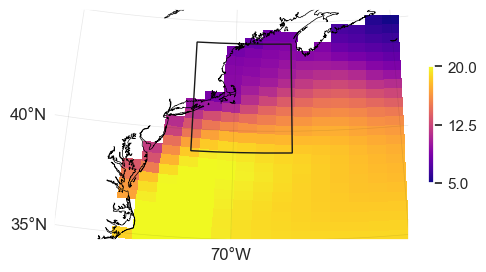

In [6]:
## blank canvas
fig = plt.figure()

## plot background
fig, ax = plot_setup_woodshole(fig)


## plot the data
plot_data = ax.pcolormesh(
    data.TLONG,
    data.TLAT,
    data.isel(member=0, time=0),
    # cmap="cmo.thermal",
    cmap = "plasma",
    vmax=20,
    vmin=5,
    transform=ccrs.PlateCarree(),
)

## make a colorbar
cb = fig.colorbar(plot_data, fraction=0.015, pad=0.05, ticks=[5, 12.5, 20])

## plot outline of region
ax = plot_box_outline(ax, lon_range=[287.5, 293.5], lat_range=[39, 44])

plt.show()

## Statistics

### Compute index

````{admonition} To-do
If you'd like to look at a different index, modify the function below.
````

In [7]:
def compute_T_wh(x):
    """Compute Woods Hole temperature index"""

    ## get subset of data inside the box
    data_subset = trim(x, lon_range=[287.5, 293.5], lat_range=[39, 44])

    ## compute spatial average
    return data_subset.mean(["nlon", "nlat"])


## do the computation here
idx = compute_T_wh(data)

## Separate forced response from internal variability

Estimate forced response and internval variability

In [8]:
## define forced response as ensemble mean
idx_forced = idx.mean("member")

## internal variability is the residual
idx_iv = idx - idx_forced

## compute annual means
get_ann_mean = lambda x: x.groupby("time.year").mean().sel(year=slice(None, 2080))
idx_forced_ann = get_ann_mean(idx_forced)
idx_iv_ann = get_ann_mean(idx_iv)
idx_ann = get_ann_mean(idx)

Lets plot the annual mean

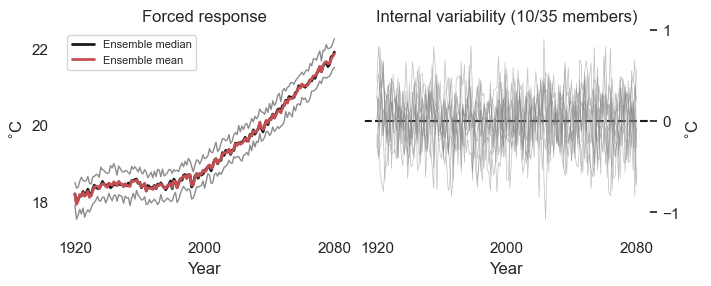

In [9]:
## set up plot
fig, axs = plt.subplots(1, 2, figsize=(7, 2.75), layout="constrained")

## plot ensemble median and 10%/90% percentiles
plot_quantiles(axs[0], idx_ann, c="k", time_dim="year", label="Ensemble median")

## plot forced response (ensemble mean)
axs[0].plot(idx_forced_ann.year, idx_forced_ann, c="r", lw=2, label="Ensemble mean")

## plot internval variability
kwargs = dict(lw=0.5, alpha=0.5, c="gray")
for m in idx_iv_ann.member[:10]:
    axs[1].plot(idx_iv_ann.year, idx_iv_ann.sel(member=m), **kwargs)


## label plots
for ax in axs:
    ax.set_xticks([1920, 2000, 2080])
    ax.set_xlabel("Year")
    ax.set_ylabel(r"$^{\circ}$C")

axs[0].set_yticks([18, 20, 22])
axs[1].set_yticks([-1, 0, 1])
axs[0].set_title("Forced response")
axs[1].set_title("Internal variability (10/35 members)")
axs[1].axhline(0, ls="--", c="k", zorder=0.5)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
axs[0].legend(prop=dict(size=8))

## save fig
if SAVE_FIGS:
    fig.savefig("figs/forced-response.svg")

plt.show()

## Compare warming rates in Mar and Sep

Compute rolling mean temperature for March and September

In [10]:
## function to select month
sel_month = lambda x, month: x.sel(time=(x.time.dt.month == month))

## function to normalize by first 10 timesteps
normalize = lambda x: x - x.isel(time=slice(None, 10)).mean(["member", "time"])

## get smoothed version of index
idx_smooth = get_rolling_mean(idx, by_month=True, window_size=9)

## compute values for Mar/
idx_mar_norm = normalize(sel_month(idx_smooth, 3))
idx_sep_norm = normalize(sel_month(idx_smooth, 9))

Plot forced response for Mar/Sep

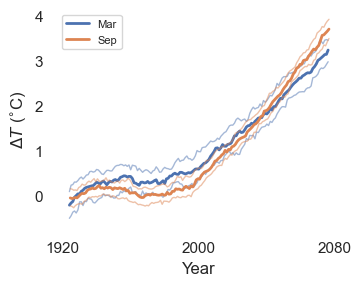

In [11]:
## get colors for plot
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(3.5, 2.75), layout="constrained")

## plot data
plot_quantiles(ax, idx_mar_norm, c=colors[0], label="Mar")
plot_quantiles(ax, idx_sep_norm, c=colors[1], label="Sep")

## label
ax.legend(prop=dict(size=8))
ax.set_ylabel(r"$\Delta T$ ($^{\circ}$C)")
ax.set_xticks(["1920", "2000", "2080"])
ax.set_xlabel("Year")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

## save to file
if SAVE_FIGS:
    fig.savefig("figs/forced-response_by-seasonal.svg")

plt.show()

Compute temperature change over two pairs of periods

In [12]:
def get_delta_T_pdf(T, t0, t1, bin_edges):
    """function to compute PDFs of temperature difference between two periods"""

    ## get delta T
    delta_T = T.sel(time=t1).squeeze() - T.sel(time=t0).squeeze()

    ## create PDF
    pdf, _ = get_empirical_pdf(delta_T, bin_edges)

    return pdf


## specify params for PDF
kwargs0 = dict(t0="1924", t1="2000", bin_edges=np.arange(-0.3, 1.9, 0.15))
kwargs1 = dict(t0="2000", t1="2076", bin_edges=np.arange(2, 4.5, 0.2))

## compute PDFs for each period
pdf_mar_0 = get_delta_T_pdf(idx_mar_norm, **kwargs0)
pdf_sep_0 = get_delta_T_pdf(idx_sep_norm, **kwargs0)
pdf_mar_1 = get_delta_T_pdf(idx_mar_norm, **kwargs1)
pdf_sep_1 = get_delta_T_pdf(idx_sep_norm, **kwargs1)

Plot result

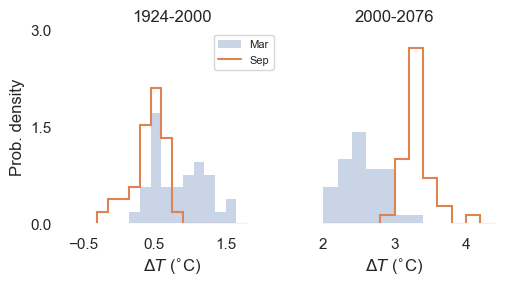

In [13]:
## Set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2.75), layout="constrained")

## plot style for march
mar_kwargs = dict(fill=True, alpha=0.3, label="Mar")
sep_kwargs = dict(lw=1.5, label="Sep")

## plot temperature change for first period
axs[0].stairs(pdf_mar_0, edges=kwargs0["bin_edges"], **mar_kwargs)
axs[0].stairs(pdf_sep_0, edges=kwargs0["bin_edges"], **sep_kwargs)

## plot for second period
axs[1].stairs(pdf_mar_1, edges=kwargs1["bin_edges"], **mar_kwargs)
axs[1].stairs(pdf_sep_1, edges=kwargs1["bin_edges"], **sep_kwargs)

## set axis limits
axs[0].set_xlim([-0.75, 2.25])
axs[1].set_xlim([1.5, 4.5])
for ax in axs:
    ax.set_ylim([0, 3])

## label
axs[0].legend(prop=dict(size=8))
axs[0].set_title(f"{kwargs0['t0']}-{kwargs0['t1']}")
axs[1].set_title(f"{kwargs1['t0']}-{kwargs1['t1']}")
axs[0].set_xticks([-0.5, 0.5, 1.5])
axs[1].set_xticks([2, 3, 4])
axs[0].set_yticks([0, 1.5, 3])
axs[1].set_yticks([])
axs[0].set_ylabel("Prob. density")
for ax in axs:
    ax.set_xlabel(r"$\Delta T$ ($^{\circ}$C)")

## save to file
if SAVE_FIGS:
    fig.savefig("figs/histograms.svg")

plt.show()

## Look at change in standard deviation (spatial pattern)

In [14]:
## get internval variability signal
data_iv = data - data.mean("member")

## compute standard dev over first/last 30 years of simulation
std_init = data_iv.isel(time=slice(None, 360)).std(["time", "member"], skipna=False)
std_end = data_iv.isel(time=slice(-360, None)).std(["time", "member"], skipna=False)

## get percentage change
std_pct_change = 100 * (std_end - std_init) / std_init

### Plot initial standard deviation result 

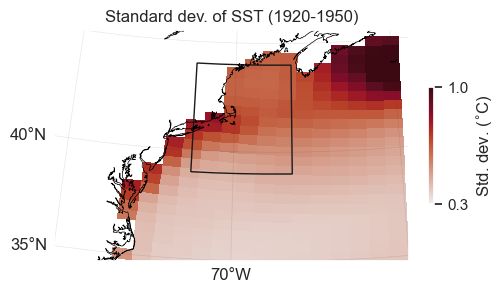

In [15]:
## blank canvas
fig = plt.figure()

## plot background
fig, ax = plot_setup_woodshole(fig)


## plot the data
plot_data = ax.pcolormesh(
    std_init.TLONG,
    std_init.TLAT,
    std_init,
    cmap="cmo.amp",
    vmax=1,
    vmin=0.3,
    transform=ccrs.PlateCarree(),
)

## make a colorbar
cb = fig.colorbar(
    plot_data,
    fraction=0.015,
    pad=0.05,
    ticks=[0.3, 1],
    label=r"Std. dev. ($^{\circ}$C)",
)

## plot outline of region
ax = plot_box_outline(ax, lon_range=[287.5, 293.5], lat_range=[39, 44])

## Label
ax.set_title("Standard dev. of SST (1920-1950)")

plt.show()

### Plot % change

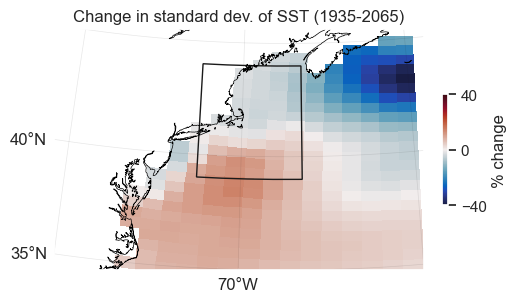

In [16]:
## blank canvas
fig = plt.figure(layout="constrained")

## plot background
fig, ax = plot_setup_woodshole(fig)


## plot the data
plot_data = ax.pcolormesh(
    std_init.TLONG,
    std_init.TLAT,
    std_pct_change,
    cmap="cmo.balance",
    vmax=40,
    vmin=-40,
    transform=ccrs.PlateCarree(),
)

## make a colorbar
cb = fig.colorbar(
    plot_data, fraction=0.015, pad=0.05, ticks=[-40, 0, 40], label="% change"
)

## plot outline of region
ax = plot_box_outline(ax, lon_range=[287.5, 293.5], lat_range=[39, 44])

## label
ax.set_title("Change in standard dev. of SST (1935-2065)")

## save to  file
if SAVE_FIGS:
    fig.savefig("figs/sigma-change.svg")

plt.show()